# Inpainting di immagini satellitari

Il progetto riguarda il inpainting (ritocco) di immagini, che consiste nel riempire parti deteriorate o mancanti di un'immagine per ricostruire un'immagine completa.

Il dataset preso in considerazione è il dataset EuroSAT di tensorflow basato su immagini satellitari Sentinel-2, nella versione rgb. Questo comprende 27000 immagini, a risoluzione 64x64.

Una porzione dell'immagine viene mascherata casualmente secondo la procedura descritta di seguito. Il tuo obiettivo è ricostruire l'immagine completa.



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

###Dataset


In [ ]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

In [ ]:
ds_train = ds_train['train']

In [ ]:
ds_train = ds_train.shuffle(1000, seed = 42)

In [ ]:
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

Il generatore fornisce i vostri dati di addestramento. Creiamo una maschera disegnando linee verticali casuali con angoli diversi e con larghezza variabile. La porzione dell'immagine conservata è quella sotto la maschera.


## Generatore

Di seguito e' presente il generatore fornito per il progetto.

In [ ]:
def generator(dataset,nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 100
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)

Visualizziamo i dati. Nella prima riga mostriamo le immagini deteriorate, e nella seconda gli originali che devono essere ricostruiti.


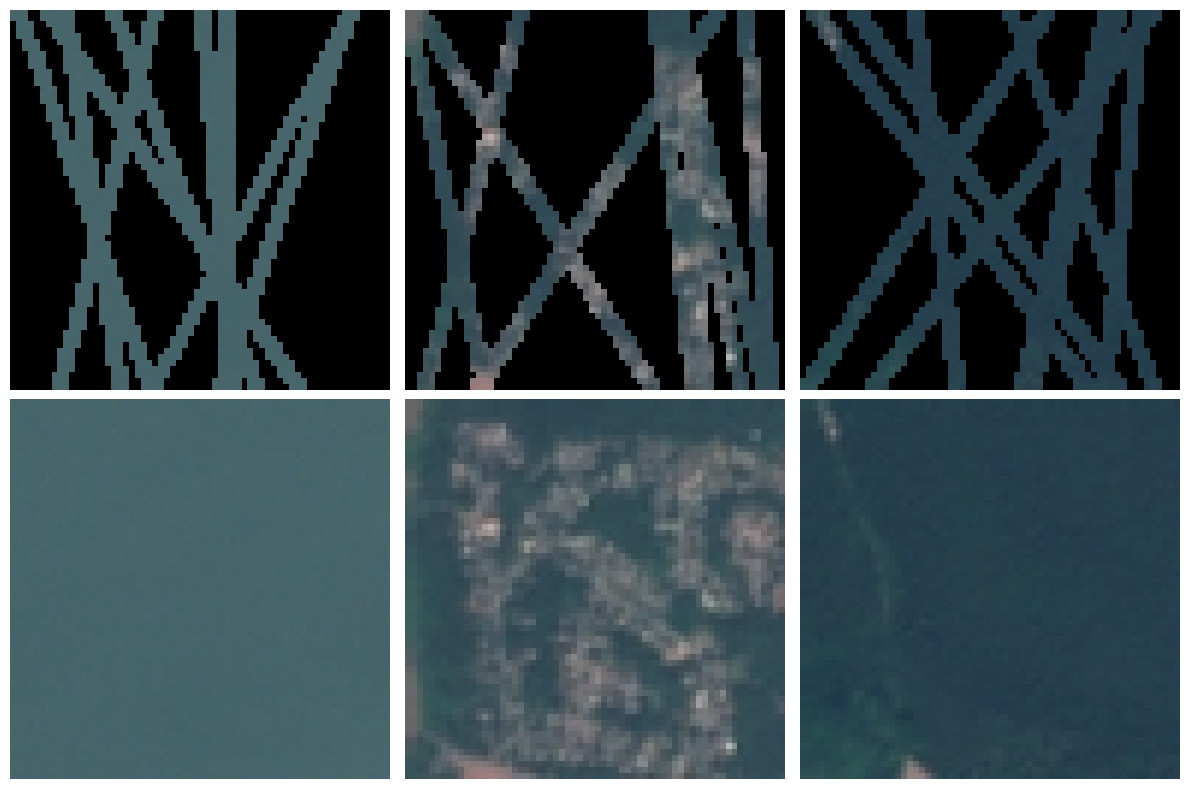

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

## Cosa consegnare; metrica di valutazione

La rete deve essere scritta in tensorflow/keras.

Come al solito, dovete consegnare un unico notebook, contenente una traccia completa dell'addestramento della vostra rete. Potete utilizzare qualsiasi funzione di loss durante l'addestramento.

Per valutare la qualità della vostra ricostruzione utilizzate l'mse. Calcolatelo su 10000 immagini generate dal set di test. Ripetete il calcolo precedente 10 volte e fornite il valore medio e la deviazione standard.

## Buon lavoro!



In [ ]:
from tensorflow import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler

## Descrizione del modello
Il modello utilizzato si riferisce, come base di partenza, all'articolo  [Introduction to image inpainting with deep learning](https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5). Sono stati apportati dei cambiamenti per due motivi:
- le dimensioni delle immagini sono differenti (32x32 rispetto a 64x64)
- migliorare le performance

In particolare, le modifiche comprendono l'utilizzo di:
- BatchNormalitation layer dopo i convolution layer, in modo da rendere la rete piu' stabile e veloce
- Dropout layer per evitare overfitting del modello andando a disattivare casualmente i neuroni
- Maxpooling layer che permette il downsampling dell'input
- Transposed convolutional layer che permette l'upsampling dell'input


In conclusione, il modello ha un'architettura che si ispira a quello della U-net

In [ ]:
def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu', dropout=0.5):
  conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
  conv = BatchNormalization()(conv)
  conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
  pool = MaxPooling2D(pool_size=(2, 2))(conv)
  pool = BatchNormalization()(pool)
  pool = Dropout(dropout)(pool)
  return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu',dropout=0.5):
  up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
  concat = concatenate([up, skip], axis=3)
  conv = Dropout(dropout)(concat)
  conv = Conv2D(filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
  conv = BatchNormalization()(conv)
  conv = Conv2D(filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
  conv = BatchNormalization()(conv)
  return conv

In [ ]:
def nn():
  inputs = Input((64, 64, 3))
  # Down Blocks
  conv1, pool1 = down_block(inputs, filters=64, dropout=0.25)
  conv2, pool2 = down_block(pool1, filters=128)
  conv3, pool3 = down_block(pool2, filters=256)

  # bottleneck
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

  # Up Blocks
  conv5 = up_block(conv4, skip=conv3, filters=256)
  conv6 = up_block(conv5, skip=conv2, filters=128)
  conv7 = up_block(conv6, skip=conv1, filters=64)

  conv8 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv7)
  return Model(inputs=[inputs], outputs=[conv8])

## Iperparametri
Dopo diversi tentativi ho optato per i seguenti valori per gli iperparametri:
- Batch size = 100
- Epoche = 30
- PATIENCE = 4
- Learning rate = 1e-3

Nota:
- 30 e' il **numero massimo** di epoche su cui la rete si puo' allenare (vedere sezione "Ottimizzatore e callbacks")
- Dopo numerosi tentativi per trovare il learning rate migliore ho optato per adattarlo durante il training, facendolo partire da un valore alto (0.001) e riducendolo seguendo lo schema dello Step Decay.

In [ ]:
EPOCHS = 30
BATCH_SIZE = batch_size

# Early stopping
PATIENCE = 4

# Learning rate
LEARNING_RATE = 1e-3
DECAY_FACTOR = 0.75
STEP_LR = 4

## Ottimizzatore e callbacks
Per evitare l'overfitting del modello utilizzo l'Early Stopping: dopo PATIENCE epoche in cui non si registra un miglioramento sulla loss, l'allenamento termina.

Per quanto riguarda la modifica del LearningRate durante il training, ho scelto di utilizzare lo Step Decay
Schedule, ovvero il learning rate viene moltiplicato con un fattore 0*75 ogni 4 epoche. In tal modo si verrà a creare una discesa del learning rate a scalino. In questo modo è possibile ridurre il tempo di training e migliorare le performance.


In [ ]:
EARLY_STOPPING = EarlyStopping(monitor='loss', mode='min', patience=PATIENCE)

In [ ]:
OPTIMIZER = tf.keras.optimizers.legacy.Adam(learning_rate = LEARNING_RATE)

def step_decay_schedule(initial_lr, decay_factor, step_size):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)

LR_SCHEDULE = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=DECAY_FACTOR, step_size=STEP_LR)


## Training

In [ ]:
model = nn()
model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy', 'mean_squared_error'])

### Visualizzazione del modello

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 64, 64, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 64, 64, 64)           256       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_16 (Conv2D)          (None, 64, 64, 64)           36928     ['batch_normalization_12

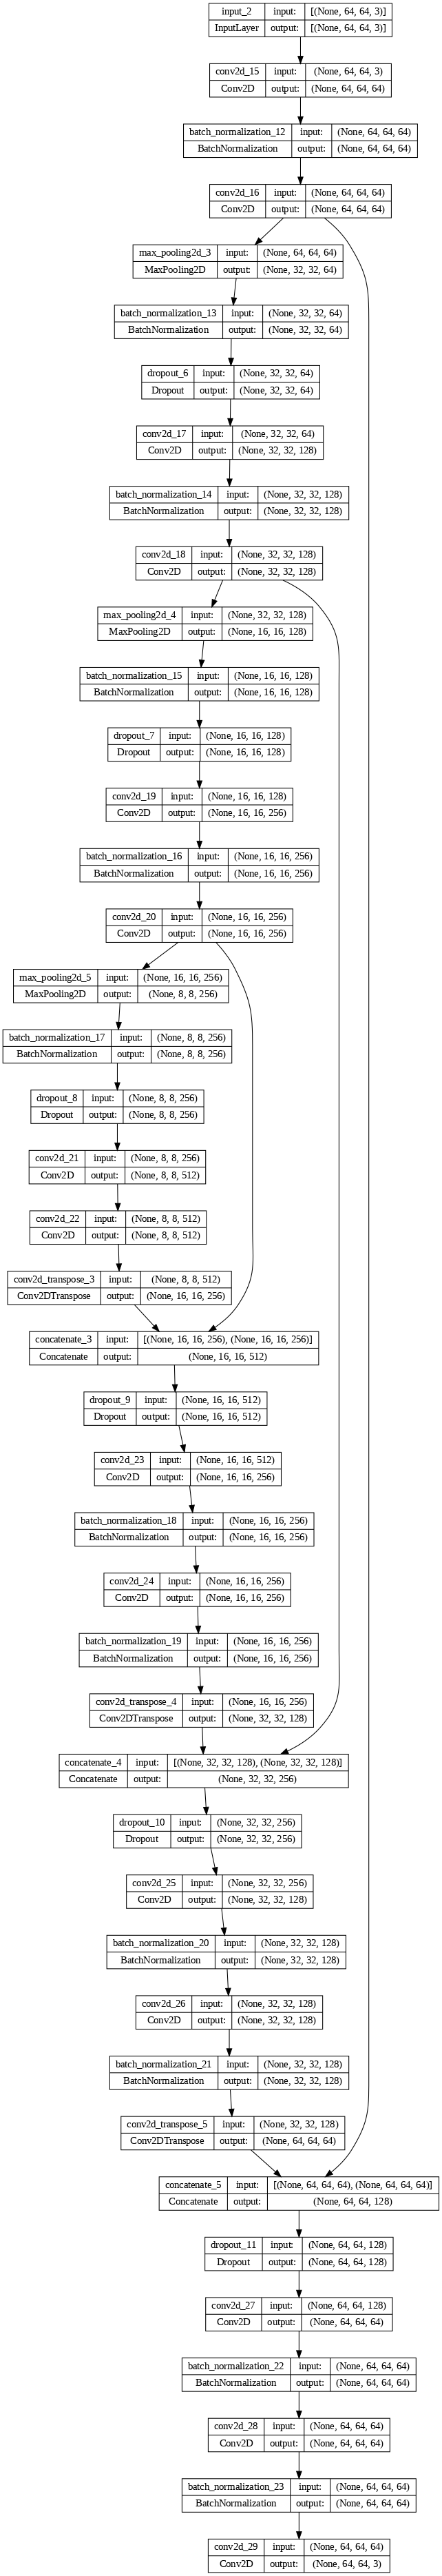

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [ ]:
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=(20000 // BATCH_SIZE), callbacks = [EARLY_STOPPING, LR_SCHEDULE])

Epoch 1/30
200/200 [==============================] - 79s 367ms/step - loss: 0.6261 - accuracy: 0.7242 - mean_squared_error: 0.0087 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 72s 361ms/step - loss: 0.6141 - accuracy: 0.8118 - mean_squared_error: 0.0041 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 72s 360ms/step - loss: 0.6131 - accuracy: 0.8344 - mean_squared_error: 0.0037 - lr: 0.0010
Epoch 4/30
200/200 [==============================] - 72s 361ms/step - loss: 0.6128 - accuracy: 0.8438 - mean_squared_error: 0.0035 - lr: 0.0010
Epoch 5/30
200/200 [==============================] - 72s 360ms/step - loss: 0.6125 - accuracy: 0.8493 - mean_squared_error: 0.0034 - lr: 7.5000e-04
Epoch 6/30
200/200 [==============================] - 72s 361ms/step - loss: 0.6125 - accuracy: 0.8545 - mean_squared_error: 0.0034 - lr: 7.5000e-04
Epoch 7/30
200/200 [==============================] - 72s 360ms/step - loss: 0.6123 - accuracy: 0.8594 - mean_squared_erro

## Visualizzazione delle metriche sul training

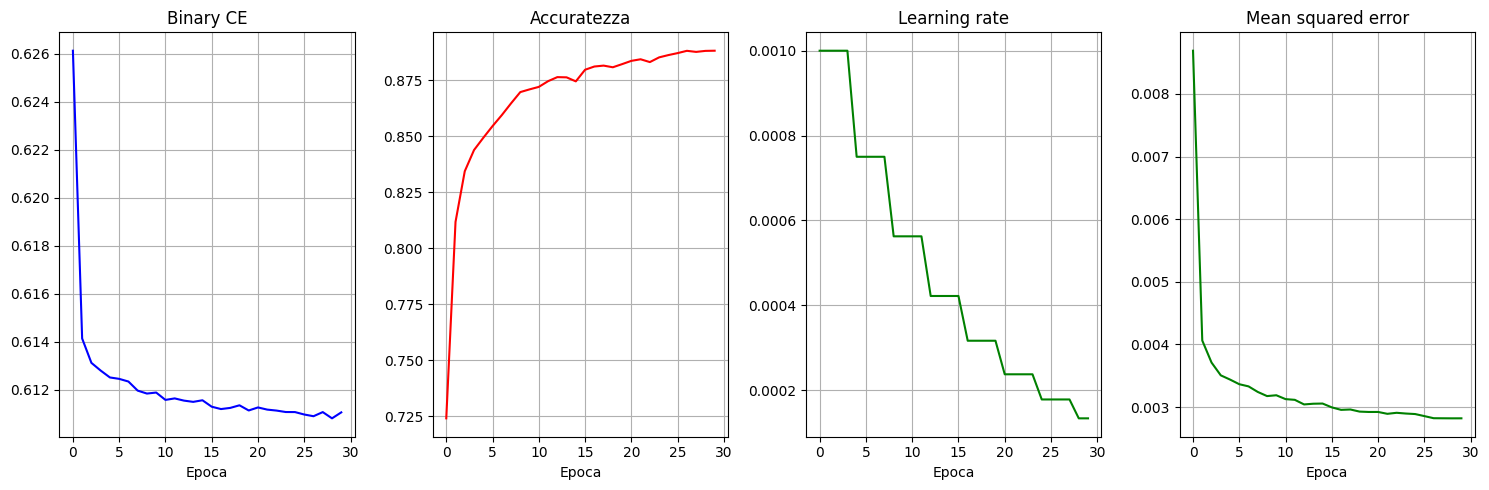

In [ ]:
def plot_metrics(history):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))  # Imposta la dimensione della figura

    axes[0].plot(history.history['loss'], color='blue')
    axes[0].set_title("Binary CE")
    axes[0].set_xlabel("Epoca")
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], color='red')
    axes[1].set_title("Accuratezza")
    axes[1].set_xlabel("Epoca")
    axes[1].grid(True)

    axes[2].plot(history.history['lr'], color='green')
    axes[2].set_title("Learning rate")
    axes[2].set_xlabel("Epoca")
    axes[2].grid(True)

    axes[3].plot(history.history['mean_squared_error'], color='green')
    axes[3].set_title("Mean squared error")
    axes[3].set_xlabel("Epoca")
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

# Utilizzo della funzione
plot_metrics(history)


# Visualizzazione delle immagini generate

4/4 [==============================] - 4s 300ms/step


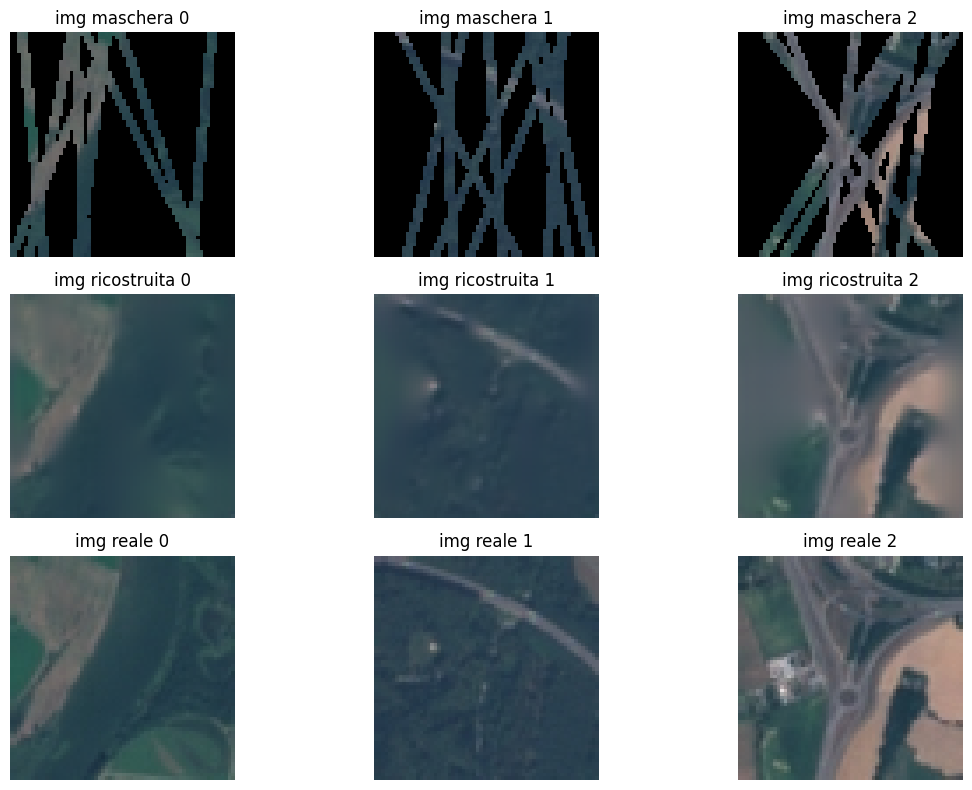

In [ ]:
def showImages(x, y, z, customNcols=3, customFigSize=(12,8)):
  # Adjust figsize as needed
  fig, axes = plt.subplots(nrows=3, ncols=customNcols, figsize=customFigSize)

  # Plot image on each subplot
  for i in range(customNcols):
    axes[0,i].imshow(x[i])  # Use cmap='gray' if your images are grayscale
    axes[0,i].axis('off') # Turn off axis
    axes[0,i].title.set_text(f"img maschera {i}")
    axes[1,i].imshow(y[i])
    axes[1,i].axis('off')
    axes[1,i].title.set_text(f"img ricostruita {i}")
    axes[2,i].imshow(z[i])
    axes[2,i].axis('off')
    axes[2,i].title.set_text(f"img reale {i}")

  plt.tight_layout()
  plt.show()

test_x, test_y = next(test_generator)
inpainted_image = model.predict(test_x)
showImages(test_x, inpainted_image, test_y)

## Valutazione del modello
Si calcola il mse su 10000 immagini generate dal set di test per 10 volte e si fornisce il valore medio e la deviazione standard.

In [ ]:
no_batch = 10000 // BATCH_SIZE
mse_scores = []

for i in range(10):
  for j in range(no_batch):
    mse = tf.keras.losses.MeanSquaredError()
    test_x, test_y = next(test_generator)
    prediction = model.predict(test_x, verbose=0)
    mse_value = mse(test_y, prediction)
    mse_scores.append(mse_value)

mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'Mean MSE: {mean_mse}, Std MSE: {std_mse}')

Mean MSE: 0.00253840209916234, Std MSE: 0.0003333303320687264


## Commento
Inizialmente sono partito da un modello basilare di GAN, da questo ho poi provato ad aggiungere altri layer ma non ho riscontrato dei buoni risultati e il tempo per allenarlo era decisamente alto. Di conseguenza ho preferito utilizzare un modello più semplice ispirandomi alla U-net. Per una descrizione più dettagliata vedere la sezione "Descrizione del modello"